# Machine Learning Predictons

In [26]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings("ignore")
sns.set_theme()

file_path = r"..\data\processed\cleaned-telco-customer-churn.csv"
df = pd.read_csv(file_path)

### Define features and targets

In [49]:
df = df.drop("Unnamed: 0", axis=1)
X = df.drop("Churn", axis=1)
y = df["Churn"]

# x contains one-hot encoded columns and numeric columns



### Split data

In [50]:
# 70:30 training and testing split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

### Logistic Regression 

Logistic Regression - Confusion Matrix: 
[[1131  424]
 [ 107  448]]


Logistic Regression - Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1555
           1       0.51      0.81      0.63       555

    accuracy                           0.75      2110
   macro avg       0.71      0.77      0.72      2110
weighted avg       0.81      0.75      0.76      2110

Random Forest - ROC AUC:  0.8370771414501319


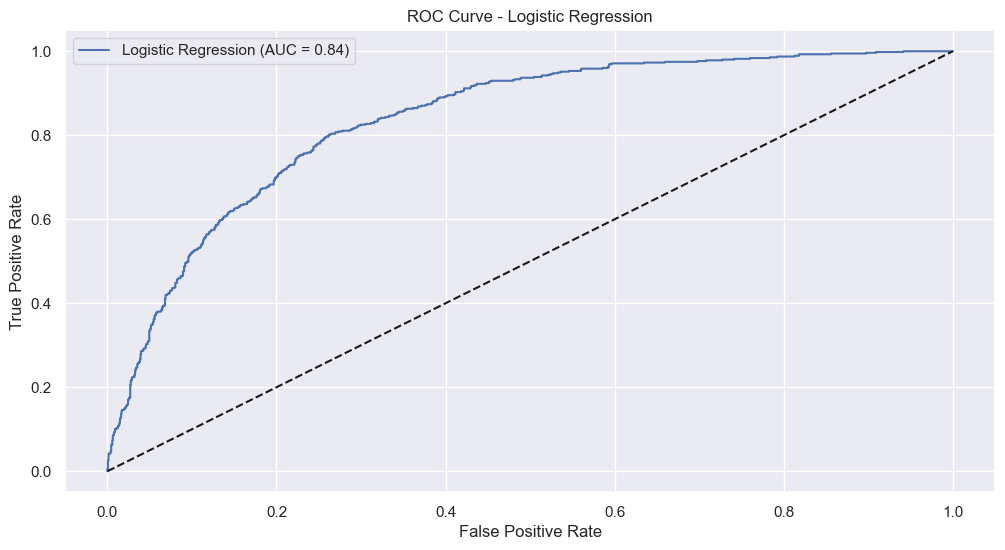

In [51]:
# fix imbalanced churn distribution using class weight method 
lr_model = LogisticRegression(max_iter=1000, class_weight="balanced")
# train the model
lr_model.fit(X_train, y_train)

# Predict test sample 
y_prediction_lr = lr_model.predict(X_test)
y_probability_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression - Confusion Matrix: ") # summary of correct and incorrect predictions 
print(confusion_matrix(y_test, y_prediction_lr))
print("\n")
print("Logistic Regression - Classification Report: ") # tells you what proportion of predicted churn cases are actually churn. 
print(classification_report(y_test, y_prediction_lr))
rocauc_score = roc_auc_score(y_test, y_probability_lr)
print("Random Forest - ROC AUC: ", rocauc_score)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probability_lr)
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {rocauc_score:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


1) Confusion Matrix:
    - 1131 True Negatives - Correctly predicted non-churners
    - 424 False Positives - Predicted churn but are non-churners 
    - 107 False Negatives - Predicted non-churn but they are churners
    - 448 True Positives - Corretly predicted churners
    
    So, we have good overall accuracy as majority of non churners are predicted correctly - Only 109 churners were predicted incorrectly.

2) Classificatoin Report:
    - 0.51 Class 1 Precision - When model predicts churn, it is correct 51% of the time 
    - 0.8 Class 1 Recall - Model caputrues 80% of all actual churners
    - 0.75 Accuracy - 3/4 predictions are correct

    So, we have high recall for churn, but we only have moderate precision for churn predictions, giving us false alarms. 

3) ROC AUC Score 
    - 0.84 Logstic Regression and Random Forest AUC - Both models peform similar, so RF will not outpeform the model we used (LR). 
    

### Predict for new customers with a gui

In [54]:
import tkinter as tk
from tkinter import ttk, messagebox 


# map raw features to readable formats
static_features = {
    "SeniorCitizen": "Senior Citizen (0 = No, 1 = Yes)",
    "Partner": "Has Partner? (0 = No, 1 = Yes)",
    "Dependents": "Has Dependents? (0 = No, 1 = Yes)",
    "tenure": "Tenure (months)",
    "PhoneService": "Phone Service Active? (0 = No, 1 = Yes)",
    "PaperlessBilling": "Paperless Billing? (0 = No, 1 = Yes)",
    "MonthlyCharges": "Monthly Charges",
    "TotalCharges": "Total Charges",
    "gender_Male": "Gender (1 = Male, 0 = Female)",
    "InternetService_Fiber optic": "Fiber Optic Internet? (0 = No, 1 = Yes)",
    "InternetService_No": "No Internet Service? (0 = No, 1 = Yes)",
    "Contract_One year": "Contract: One Year (0 = No, 1 = Yes)",
    "Contract_Two year": "Contract: Two Year (0 = No, 1 = Yes)",
    "PaymentMethod_Credit card (automatic)": "Payment Method: Credit Card (Automatic) (0 = No, 1 = Yes)",
    "PaymentMethod_Electronic check": "Payment Method: Electronic Check (0 = No, 1 = Yes)",
    "PaymentMethod_Mailed check": "Payment Method: Mailed Check (0 = No, 1 = Yes)",
    "MultipleLines_No phone service": "Multiple Lines: No Phone Service (0 = No, 1 = Yes)",
    "MultipleLines_Yes": "Multiple Lines: Yes (0 = No, 1 = Yes)",
    "OnlineSecurity_No internet service": "Online Security: No Internet Service (0 = No, 1 = Yes)",
    "OnlineSecurity_Yes": "Online Security: Yes (0 = No, 1 = Yes)",
    "OnlineBackup_No internet service": "Online Backup: No Internet Service (0 = No, 1 = Yes)",
    "OnlineBackup_Yes": "Online Backup: Yes (0 = No, 1 = Yes)",
    "DeviceProtection_No internet service": "Device Protection: No Internet Service (0 = No, 1 = Yes)",
    "DeviceProtection_Yes": "Device Protection: Yes (0 = No, 1 = Yes)",
    "TechSupport_No internet service": "Tech Support: No Internet Service (0 = No, 1 = Yes)",
    "TechSupport_Yes": "Tech Support: Yes (0 = No, 1 = Yes)",
    "StreamingTV_No internet service": "Streaming TV: No Internet Service (0 = No, 1 = Yes)",
    "StreamingTV_Yes": "Streaming TV: Yes (0 = No, 1 = Yes)",
    "StreamingMovies_No internet service": "Streaming Movies: No Internet Service (0 = No, 1 = Yes)",
    "StreamingMovies_Yes": "Streaming Movies: Yes (0 = No, 1 = Yes)"
}

# numeric features
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]

# hold entry widgets
entries = {}


def predict_churn():
    input_data = {}
    for feature, label_text in static_features.items():
        value = entries[feature].get()
        if feature in numeric_features:
            input_data[feature] = [float(value)]
        else:
            input_data[feature] = [int(value)]
    
    # dataframe with same feature names as expected by model
    new_customer_df = pd.DataFrame(input_data)

    # get probability of churn and binary prediction 
    churn_probability = lr_model.predict_proba(new_customer_df)[:, 1][0]
    churn_prediction = lr_model.predict(new_customer_df)[0]

    result = f"Churn Probability: {churn_probability:.2f}\nPrediction: {churn_prediction}"
    result_t.set(result)

# main window
root = tk.Tk()
root.title("Churn Prediction GUI")

# scrollbar 
canvas = tk.Canvas(root)
scrollbar = ttk.Scrollbar(root, orient="vertical", command=canvas.yview)
scrollable_frame = ttk.Frame(canvas)
scrollable_frame.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))
canvas.create_window((0,0), window=scrollable_frame, anchor="nw")
canvas.configure(yscrollcommand=scrollbar.set)

# entry field
row_index = 0
for feature, text in static_features.items():
    ttk.Label(scrollable_frame, text=text).grid(row=row_index, column=0, sticky="w", padx=6, pady=3)
    entry = ttk.Entry(scrollable_frame, width=45)
    entry.grid(row=row_index, column=1, padx=6, pady=3)
    entries[feature] = entry
    row_index+=1


# trigge prediction button
predict_btn = ttk.Button(scrollable_frame, text="Predict Consumer's Churn", command=predict_churn)
predict_btn.grid(row=row_index, column=0, columnspan=2, pady=10)

# display result
result_t = tk.StringVar()
result_label = ttk.Label(scrollable_frame, textvariable=result_t)
result_label.grid(row=row_index+1, column=0, columnspan=2, pady=10)

canvas.pack(side="left", fill="both", expand=True)
scrollbar.pack(side="right", fill="y")

root.mainloop()






#### The code above is a tool for predicting a customer's churn using the model we trained, a screenshot is shown below that shows it in action 

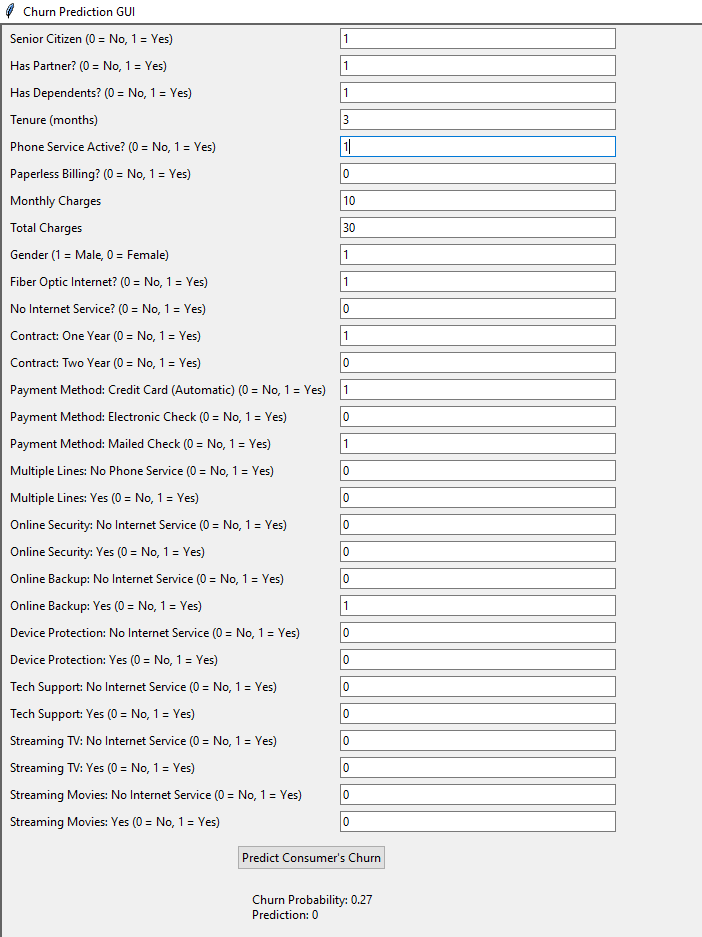

